In [13]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import h5py
from matplotlib.path import Path
import pandas as pd 
import sectionate as sec
import regionate as reg
from xgcm import Grid
import pickle 
import dask 
from dask.distributed import Client, LocalCluster
from scipy.ndimage import uniform_filter1d
import math, psutil
%matplotlib inline

In [2]:
# set up dask client


total = psutil.virtual_memory().total
usable = int(total * 0.7)              # reserve ~30%
mem_per_worker = 8 * 1024**3           # 8 GB
n_workers = max(8, min(24, usable // mem_per_worker))

# set up dask client

# good HPC defaults
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=1,
    memory_limit=str(mem_per_worker),
    local_directory="/tmp/dask-${USER}",
    dashboard_address=":8787",            # force 8787 (or ":0" for random)
    processes=True
)

client = Client(cluster)
client



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 192.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38963,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41679,Total threads: 1
Dashboard: http://127.0.0.1:43703/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42815,


In [3]:
# import dataset with mass-weighted velocity and theta for January 2007. Grid coords have been interpolated 
# to center-outer format to be usable as input to regionate package 

os.chdir('/data/globus/zkaufman')
with open("ds_MASS_xyouter_withtime.pkl", "rb") as f:
   ds_xyouter = pickle.load(f)

ds_xyouter

<xarray.Dataset> Size: 2TB
Dimensions:       (date: 31, RC: 225, YC: 2343, XO: 8641, YO: 2344, XC: 8640,
                   RF: 226)
Coordinates: (12/17)
  * date          (date) float32 124B 1.051e+06 1.053e+06 ... 1.094e+06
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XO            (XO) float32 35kB 0.0 0.04167 0.08333 ... 359.9 360.0 360.0
    DXG           (XO) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC            (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    ...            ...
  * RF            (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF           (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0
    geolon        (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0
    geolat        (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.05 -55.03
    geolon_c      (XO, YO) float32 81MB 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0
    geolat_c      (XO, YO) float32 81MB -85.5 -85.49 -85.48 ... -55.04 -55.02
Data variables:
    UVEL          (date, RC, YC, XO) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    VVEL          (date, RC, YO, XC) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    THETA         (date, RC, YC, XC) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    deptho_on_uv  (YO, XO) float32 81MB 0.0 0.0 0.0 ... 1.871e+03 1.744e+03
    areacello     (YC, XC) float32 81MB 3.638e+05 3.638e+05 ... 7.05e+06

In [4]:
# build xGCM grid object 

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)

In [5]:
# for efficiency in this demo, we will use the first time step only 

ds_xyouter['UVEL'] = ds_xyouter['UVEL'][0,:,:,:].squeeze()
ds_xyouter['VVEL'] = ds_xyouter['VVEL'][0,:,:,:].squeeze()
ds_xyouter['THETA'] = ds_xyouter['THETA'][0,:,:,:].squeeze()

In [6]:
# reference theta to shelf freezing temperature of -2.69 deg. C 

TH = ds_xyouter["THETA"] - (2.69*-1) # (RC, YC, XC) 
U  = ds_xyouter["UVEL"]              # (RC, YC, XO)
V  = ds_xyouter["VVEL"]              # (RC, YO, XC)
AREA = ds_xyouter["areacello"]       # (YC, XC)

In [7]:
# to get heat transport, we need to interpolate 
# tracer (theta) onto the velocity grid. 

#  “normal” chunks to keep graphs small
NORMAL = {"RC": 40, "YC": 512, "XC": 512, "XO": 512, "YO": 512}

# X interpolation: only make XC contiguous
TH_on_u = grid.interp(TH.chunk({"XC": -1}), "X")          # (RC, YC, XO)
TH_on_u = TH_on_u.chunk({"YC": NORMAL["YC"], "XO": NORMAL["XO"]})
# Y interpolation: only make YC contiguous
TH_on_v = grid.interp(TH.chunk({"YC": -1}), "Y")          # (RC, YO, XC)
TH_on_v = TH_on_v.chunk({"YO": NORMAL["YO"], "XC": NORMAL["XC"]})

In [8]:
# calculate x and y components of temperature advection (units kelvin per second)

# fluxes on faces
Fx = (U * TH_on_u).astype("float32")
Fy = (V * TH_on_v).astype("float32")

# chunk dx, dy for calculating spatial gradients 
DXC = ds_xyouter["DXC"].chunk({"XC": NORMAL["XC"]})
DYC = ds_xyouter["DYC"].chunk({"YC": NORMAL["YC"]})
DXG = ds_xyouter["DXG"].chunk({"XO": NORMAL["XO"]})
DYG = ds_xyouter["DYG"].chunk({"YO": NORMAL["YO"]})

# Fx: XO -> XC (center)
Fx_c = grid.interp(Fx.chunk({"XO": -1}), "X", to="center")
Fx_c = Fx_c.chunk({"XC": NORMAL["XC"], "YC": NORMAL["YC"]})

# Fy: YO -> YC (center)
Fy_c = grid.interp(Fy.chunk({"YO": -1}), "Y", to="center")
Fy_c = Fy_c.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})

# ---- diffs need contiguous axis too ----
# d/dx at u-faces (X): input uses XC, so make XC contiguous before diff
dFx_dx_on_u = grid.diff(Fx_c.chunk({"XC": -1}), "X") / DXG
dFx_dx_on_u = dFx_dx_on_u.astype("float32").chunk({"YC": NORMAL["YC"], "XO": NORMAL["XO"]})

# d/dy at v-faces (Y): input uses YC, so make YC contiguous before diff
dFy_dy_on_v = grid.diff(Fy_c.chunk({"YC": -1}), "Y") / DYG
dFy_dy_on_v = dFy_dy_on_v.astype("float32").chunk({"YO": NORMAL["YO"], "XC": NORMAL["XC"]})

/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(


In [9]:
# chunk AREA since it wasn't chunked before, and interpolate to velocity grid  
AREA = AREA.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})
AREA_on_u = grid.interp(AREA.chunk({"XC": -1}), "X")          # (RC, YC, XO)
AREA_on_u = AREA_on_u.chunk({"YC": NORMAL["YC"], "XO": NORMAL["XO"]})
AREA_on_v = grid.interp(AREA.chunk({"YC": -1}), "Y")          # (RC, YO, XC)
AREA_on_v = AREA_on_v.chunk({"YO": NORMAL["YO"], "XC": NORMAL["XC"]})


# add temperature advection fields to dataset
# multiply by rho, cp, AREA, and cell thickness to obtain units of watts 

rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K
thick = ds_xyouter['DRF']
ds_xyouter['T_adx'] = dFx_dx_on_u*rho0*Cp*thick*AREA_on_u
ds_xyouter['T_ady'] = dFy_dy_on_v*rho0*Cp*thick*AREA_on_v

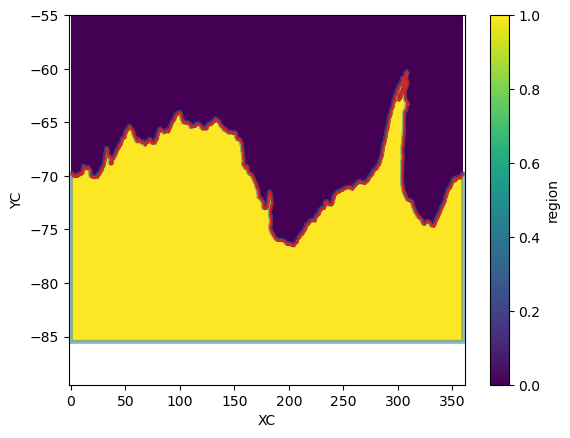

In [10]:
# using bathymetry, build antarctic margin regionate region from the 1000m isobath 

ds_xyouter["deptho"] = grid.interp(grid.interp(ds_xyouter.deptho_on_uv, "X"), "Y")
mask = (ds_xyouter.deptho <= 1000.) 
region_dict = reg.MaskRegions(mask, grid).region_dict
region = region_dict[0] # pick out the first region, corresponding to the longest contour

name = "Antarctic margin"
region = reg.GriddedRegion(
    name,
    region.lons_c[::-1], # reverse direction so that the boundary has a west-to-east orientation
    region.lats_c[::-1],
    grid,
    ij=(region.i_c[::-1], region.j_c[::-1])
)

idx_without_border = (
    (region.lons_c != ds_xyouter.XO.min().values) &
    (region.lons_c != ds_xyouter.XO.max().values) &
    (region.lats_c != np.min(region.lats_c))
)

region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c, "C0-", alpha=0.5, markersize=1, lw=3, label="full region boundary")
plt.plot(region.lons_c[idx_without_border], region.lats_c[idx_without_border], "C3.-", lw=0.5, markersize=0.1, label="isobath only (ignoring grid boundaries)")
plt.ylim(-89.5, -55)
plt.xlim(-2, 362);


In [11]:
# use regionate to calculate advective fluxes normal to the shelf region boundary 
# take the vertical integral as well 

convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i_c[:-1][idx_without_border],
    region.j_c[:-1][idx_without_border],
    utr="T_adx",
    vtr="T_ady",
    layer='RC',
    interface=None,
    outname="conv_heat_transport"
)['conv_heat_transport'].sum("RC").compute()

convergent_heat_transport



/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/sectionate/transports.py:393: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")
/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 86.51 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'conv_heat_transport' (sect: 16288)> Size: 130kB
array([-2.72115806e+10, -2.96365091e+10,  2.10702587e+11, ...,
        4.04017794e+08, -1.37923703e+10, -3.04614351e+10])
Coordinates: (12/13)
    XO       (sect) float32 65kB 0.0 0.04167 0.08333 ... 359.9 359.9 359.9
    DXG      (sect) float32 65kB 363.5 363.5 363.5 363.5 ... 363.5 363.5 363.5
    YC       (sect) float32 65kB -69.73 -69.73 -69.74 ... -69.76 -69.76 -69.74
    DYC      (sect) float32 65kB 1.605e+03 1.605e+03 ... 1.602e+03 1.603e+03
  * sect     (sect) int64 130kB 0 1 2 3 4 5 ... 16283 16284 16285 16286 16287
    XC       (sect) float32 65kB 0.02083 0.0625 0.1042 ... 359.9 359.9 359.9
    ...       ...
    YO       (sect) float32 65kB -69.73 -69.73 -69.75 ... -69.76 -69.76 -69.75
    DYG      (sect) float32 65kB 1.605e+03 1.605e+03 ... 1.603e+03 1.604e+03
    sign     (sect) int64 130kB -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 1 -1 -1 1 -1
    dir      (sect) <U1 65kB 'V' 'V' 'U' 'V' 'U' 'U' ... 'V' 'U' 'V' 'V' 'U' 'V'
    lon      (sect) float64 130kB 0.02083 0.0625 0.08333 ... 359.9 359.9 359.9
    lat      (sect) float64 130kB -69.73 -69.73 -69.74 ... -69.76 -69.76 -69.75

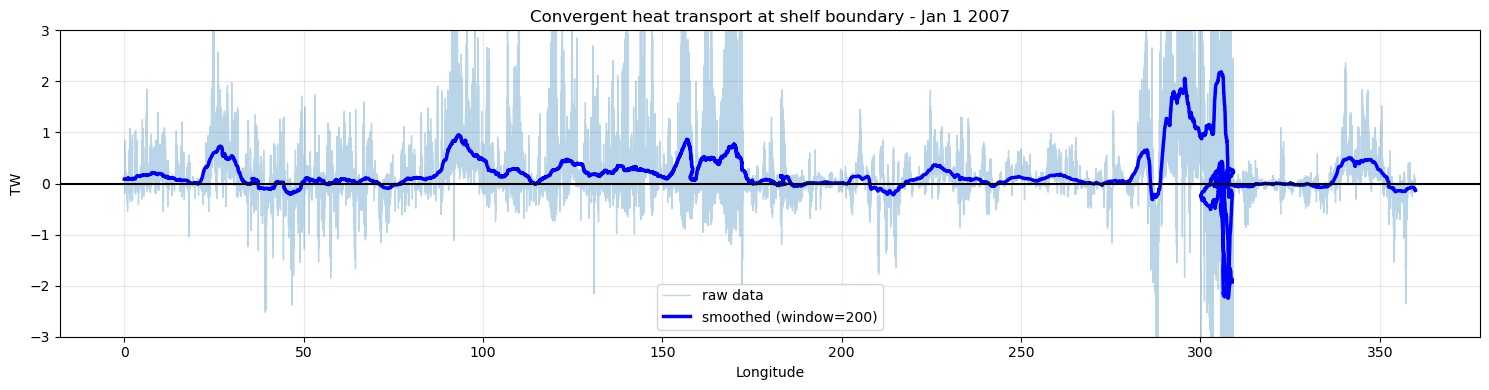

In [ ]:
# plot convergent heat transport along the boundary sections 


# convert to numpy for smoothing
y = convergent_heat_transport.values*1e-12
lons = convergent_heat_transport['lon'].values  # lon coordinate for each section point

# --- smooth the data ---
window = 200
y_smooth = uniform_filter1d(y, size=window)

# --- plot both raw + smooth curves ---
plt.figure(figsize=(15, 4))
plt.plot(lons, y, color='tab:blue', alpha=0.3, lw=1, label='raw data')
plt.plot(lons, y_smooth, color='blue', lw=2.5, label=f'smoothed (window={window})')
plt.axhline(color='k')

plt.title("Convergent heat transport at shelf boundary - Jan 1 2007")
plt.xlabel("Longitude")
plt.ylabel("TW")
plt.legend()
plt.ylim(-3,3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
# plot total 

print(np.cumsum(convergent_heat_transport.values)[-1]*1e-12)
print('TW')
print('yikes!')

2448.856997537729
TW
yikes!
